# Introduction to 1D Convolutional Neural Networks for NLP
This is the code corresponding to the CNN part of my notes [Introduction to CNNs and LSTMs for NLP](http://www.lix.polytechnique.fr/~anti5662/intro_cnn_lstm_tixier.pdf). I encourage you to have a look at these notes for a quick theoretical intro.

In this notebook, we use Python 3 and [Keras](https://keras.io/getting-started/faq/}) with `TensorFlow` backend to perform binary **movie review classification** (positive/negative) on the IMDB dataset (25K training, 25K testing) with the basic CNN architecture described in [CNNs for Sentence Classification (Kim, EMNLP 2014)](https://arxiv.org/abs/1408.5882). We also visualize **document embeddings**, **predictive regions** in the input documents, following [Effective Use of Word Order for Text Categorization with Convolutional Neural Networks (Johnson and Zhang, NAACL 2015)](https://arxiv.org/pdf/1412.1058.pdf), and first-order derivate **saliency maps**, following [Visualizing and Understanding Neural Models in NLP (Li et al. 2015)](https://arxiv.org/abs/1506.01066). 


## Environment setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import csv
import json
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim.models.word2vec import Word2Vec

from keras.models import Model, load_model
from keras import backend as K
from keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

print('packages loaded')

# make sure you replace the root path with your own!
path_root = 'C:\\Users\\mvazirg\\Desktop\\M2 graph & text\\Lab4_deep_learning\\final\\final\\'
path_to_IMDB = path_root + 'data\\'
path_to_pretrained_wv = 'G:\\'
path_to_plot = path_root
path_to_save = path_root

Using TensorFlow backend.


packages loaded


## Parameter values

Let's set the values of our parameters. Below are some explanations about the role of some parameters. The others are pretty self-explanatory.
* `use_pretrained`: whether to use pre-trained word embeddings or not (convergence is faster, and absolute accuracy is slightly greater)
* `max_features`: size of our vocab
* `stpwd_thd`: number of most frequent words to consider as stopwords
* `max_size`: maximum document size allowed
* `nb_epoch`: increasing the number of epochs may lead to overfitting when max_size is small (especially since dataset is small in the first place)
* `my_optimizer`: `adam` proved better than `SGD` and `Adadelta` in my experiments
* `my_patience`: for early stopping strategy (number of epochs without improvement to wait before we stop training)

In [19]:
use_pretrained = True
name_save = 'my_cnn_test.hdf5'
print('best model will be saved with name:',name_save)

max_features = int(1e4)
stpwd_thd = 50 
max_size = 150
word_vector_dim = int(3e2)
do_static = True
nb_filters = 100
filter_size = 3
drop_rate = 0.3
batch_size = 64
nb_epoch =  5 
my_optimizer = 'adam' 
my_patience = 1

if not use_pretrained:
    # if the embeddings are initialized randomly, using static mode doesn't make sense
    do_static = False
    print("not using pre-trained embeddings, overwriting 'do_static' argument")

best model will be saved with name: my_cnn_test.hdf5


## Data loading and further preprocessing
### Reading and inspection
Let's read the data. The raw data have already been pre-processed by me in this [script](https://github.com/Tixierae/deep_learning_NLP/blob/master/imdb_preprocess.py). `word_to_index` is a dictionary of word indexes sorted by decreasing frequency across the corpus. It is a 1-based index, as 0 is reserved for zero-padding.

In [3]:
with open(path_to_IMDB + 'word_to_index.json', 'r') as my_file:
    word_to_index = json.load(my_file)

# examples:
print('index of "the":',word_to_index['the']) # most frequent word
print('index of "movie":',word_to_index['movie']) # very frequent word
print('index of "elephant":',word_to_index['elephant']) # less frequent word
print('index of "dreaded":',word_to_index['dreaded']) # very infrequent word

index of "the": 1
index of "movie": 14
index of "elephant": 4651
index of "dreaded": 11000


In [4]:
with open(path_to_IMDB + 'training.csv', 'r') as my_file:
    reader = csv.reader(my_file, delimiter=',')
    x_train = list(reader)

with open(path_to_IMDB + 'test.csv', 'r') as my_file:
    reader = csv.reader(my_file, delimiter=',')
    x_test = list(reader)

with open(path_to_IMDB + 'training_labels.txt', 'r') as my_file:
    y_train = my_file.read().splitlines()

with open(path_to_IMDB + 'test_labels.txt', 'r') as my_file:
    y_test = my_file.read().splitlines()

# turn lists of strings into lists of integers
x_train = [[int(elt) for elt in sublist] for sublist in x_train]
x_test = [[int(elt) for elt in sublist] for sublist in x_test]  

y_train = [int(elt) for elt in y_train]
y_test = [int(elt) for elt in y_test]

print('data loaded')

data loaded


We can verify what our data look like by inverting the `word_to_index` dictionary and comparing the first review to the real one: [http://www.imdb.com/title/tt0118703/reviews](http://www.imdb.com/title/tt0118703/reviews):

In [5]:
index_to_word = dict((v,k) for k, v in word_to_index.items())
print (' '.join([index_to_word[elt] for elt in x_train[0]]))

bette midler is again divine raunchily humorous in love with burlesque capable of bringing you down to tears either with old jokes with new dresses or merely with old songs with more power punch than ever all in all singing new ballads power singing the good old perennial ones such as the rose stay with me and yes even wind beneath my wings the best way to appreciate the divine miss has always been libe since this is the next best thing to it strongly recommended to all with mixture of adult wide eyed enchantment and appreciation and child's mischievous wish for pushing all boundaries


### Stopwords and out-of-vocab words removal
We only take into account the `max_features` most frequent words and disregard the `stopword_threhsold` most frequent words:

In [6]:
stpwds = [index_to_word[idx] for idx in range(1,stpwd_thd)]
print('stopwords are:',stpwds)

x_train = [[elt for elt in rev if elt<=max_features and elt>=stpwd_thd] for rev in x_train]
x_test =  [[elt for elt in rev if elt<=max_features and elt>=stpwd_thd] for rev in x_test]

print('pruning done')

stopwords are: ['the', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'be', 'one', 'he', 'all', 'at', 'by', 'an', 'they', 'so', 'who', 'from', 'like', 'or', 'just', 'her', 'out', 'about', 'if', "it's", 'has', 'there', 'some', 'what', 'good', 'when', 'more', 'very']
pruning done


### Truncation and zero-padding
We truncate reviews of size larger than `max_size` to their `max_size` first words. We also pad reviews shorter than `max_size` with the zero vector reserved for padding (0th index):

In [7]:
x_train = [rev[:max_size] for rev in x_train]
x_test = [rev[:max_size] for rev in x_test]

print('padding',len([elt for elt in x_train if len(elt)<max_size])
,'reviews from the training set')

x_train = [rev+[0]*(max_size-len(rev)) if len(rev)<max_size else rev for rev in x_train]

# sanity check: all reviews should now be of size 'max_size'
assert(max_size == list(set([len(rev) for rev in x_train]))[0]),"1st sanity check failed!"

print('padding',len([elt for elt in x_test if len(elt)<max_size]),'reviews from the test set')

x_test = [rev+[0]*(max_size-len(rev)) if len(rev)<max_size else rev for rev in x_test]

# sanity check
assert(max_size == list(set([len(rev) for rev in x_test]))[0]),"2nd sanity check failed!"

print('truncation and padding done')

padding 18888 reviews from the training set
padding 19171 reviews from the test set
truncation and padding done


### Loading pre-trained word vectors
* Note 1: when using the `intersect_word2vec_format` method, in-vocab words without an entry in the binary file are not removed from the vocabulary. Instead, their vectors are silently initialized to random values. We can detect those vectors via their norms which approach zero. This is what we do in lines 25-28. Most of those words are proper nouns, which don't have an entry in the word vectors file because we lowercased the text. Those words will start as random and be tuned during training.

* Note 2: lines 31-35, we create and fill an embedding table of size `max_features + 1`, ignoring stopword removal and truncation. E.g., if `max_features = 2e4`, reviews will be composed of integers from `1` to `2e4` (plus `0` after padding). But after truncation and stopword removal, the vocabulary size (number of unique integer values) may become smaller. So, if the input dim is based on the final vocab size, some integers in the range `[1,2e4]` won't have a row anymore in the embedding table. This is why we create the embedding lookup table based on the original `max_features +1` value, knowing that the rows of the words that have been removed just won't be looked up.  

In [9]:
# convert integer reviews into word reviews
x_full = x_train + x_test
x_full_words = [[index_to_word[idx] for idx in rev if idx!=0] for rev in x_full]
all_words = [word for rev in x_full_words for word in rev]

print(len(all_words),'words')
print(len(list(set(all_words))),'unique words')

if use_pretrained:

    # initialize word vectors
    word_vectors = Word2Vec(size=word_vector_dim, min_count=1)

    # create entries for the words in our vocabulary
    word_vectors.build_vocab(x_full_words)

    # sanity check
    assert(len(list(set(all_words))) == len(word_vectors.wv.vocab)),"3rd sanity check failed!"

    # fill entries with the pre-trained word vectors
    word_vectors.intersect_word2vec_format(path_to_pretrained_wv + 'GoogleNews-vectors-negative300.bin.gz', binary=True)

    print('pre-trained word vectors loaded')

    norms = [np.linalg.norm(word_vectors[word]) for word in list(word_vectors.wv.vocab)] # in Python 2.7: word_vectors.wv.vocab.keys()
    idxs_zero_norms = [idx for idx, norm in enumerate(norms) if norm<0.05]
    no_entry_words = [list(word_vectors.wv.vocab)[idx] for idx in idxs_zero_norms]
    print('# of vocab words w/o a Google News entry:',len(no_entry_words))

    # create numpy array of embeddings  
    embeddings = np.zeros((max_features + 1,word_vector_dim))
    for word in list(word_vectors.wv.vocab):
        idx = word_to_index[word]
        # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
        embeddings[idx,] = word_vectors[word]
        
    print('embeddings created')

else:
    print('not using pre-trained embeddings')

4812336 words
9951 unique words
pre-trained word vectors loaded
# of vocab words w/o a Google News entry: 634
embeddings created


## Defining CNN
We define one branch of the following architecture: 

<img src="https://github.com/Tixierae/deep_learning_NLP/raw/master/cnn_illustration.png" alt="Drawing" style="width: 400px;"/>


In [10]:
my_input = Input(shape=(max_size,)) # we leave the 2nd argument of shape blank because the Embedding layer cannot accept an input_shape argument

if use_pretrained:
    embedding = Embedding(input_dim=embeddings.shape[0], # vocab size, including the 0-th word used for padding
                          output_dim=word_vector_dim,
                          weights=[embeddings], # we pass our pre-trained embeddings
                          input_length=max_size,
                          trainable=not do_static,
                          ) (my_input)
else:
    embedding = Embedding(input_dim=max_features + 1,
                          output_dim=word_vector_dim,
                          trainable=not do_static,
                          ) (my_input)

embedding_dropped = Dropout(drop_rate)(embedding)

# feature map size should be equal to max_size-filter_size+1
# tensor shape after conv layer should be (feature map size, nb_filters)
print(nb_filters,'feature maps of size',max_size-filter_size+1)

conv = Conv1D(filters = nb_filters,
              kernel_size = filter_size,
              activation = 'relu',
              )(embedding_dropped)

pooled_conv = GlobalMaxPooling1D()(conv)

pooled_conv_dropped = Dropout(drop_rate)(pooled_conv)

# we finally project onto a single unit output layer with sigmoid activation
prob = Dense(units = 1, # dimensionality of the output space
             activation = 'sigmoid',
             ) (pooled_conv_dropped)

model = Model(my_input, prob)

model.compile(loss='binary_crossentropy',
              optimizer = my_optimizer,
              metrics = ['accuracy'])

print('model compiled')

100 feature maps of size 148
model compiled


We can print a summary of the model with `model.summary()`, and access the individual layers of the model with `model.layers`, then, the input/output shape of each layer with, e.g., `model.layers[0].input_shape` or `model.layers[0].output_shape`. For instance:

In [11]:
model.summary()
model.layers[4].output_shape # dimensionality of document encodings (nb_filters)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 300)          3000300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 148, 100)          90100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total para

(None, 100)

### Number of parameters of the model
* embedding layer: the number of entries in the embedding layer (`max_features` x `word_vector_dim`)
* conv layer: `filter_size` x filter depth (`word_vector_dim`) x `nb_filters` + `nb_filters` (one bias for each filter)
* dense layer: input size x output size + one bias

In [12]:
print('total number of model parameters:',model.count_params())

total number of model parameters: 3090501


### Visualization of document embeddings before training
We extract the output of the final embedding layer (before the softmax), which gives the encoding of the input document for some documents (`n_plot`) of the test set. We then visualize a low-dimensional map of the embeddings. We can see that before training, the documents are dispersed randomly in the space (which makes sense).

plotting embeddings of first 1000 documents


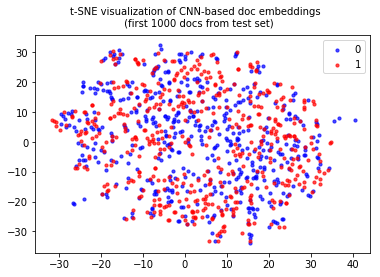

In [13]:
# in test mode, we should set the 'learning_phase' flag to 0 (we don't want to use dropout)
get_doc_embedding = K.function([model.layers[0].input,K.learning_phase()],
                               [model.layers[4].output])

n_plot = 1000
print('plotting embeddings of first',n_plot,'documents')

doc_emb = get_doc_embedding([np.array(x_test[:n_plot]),0])[0]

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
doc_emb_pca = my_pca.fit_transform(doc_emb) 
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca)

labels_plt = y_test[:n_plot]
my_colors = ['blue','red']

fig, ax = plt.subplots()

for label in list(set(labels_plt)):
    idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
    ax.scatter(doc_emb_tsne[idxs,0], 
               doc_emb_tsne[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of CNN-based doc embeddings \n (first 1000 docs from test set)',fontsize=10)
fig.set_size_inches(6,4)
#fig.savefig(path_to_plot + 'doc_embeddings_init.pdf',bbox_inches='tight')
fig.show()

## Training CNN
We train the model on CPU (warning: by default, will use all the cores of the machine!). We can get a 60-80 speedup by training it on GPU (took ~1-2 s per epoch on my Titan Xp). We also add two callbacks:
* the first one ensures that training stops after `my_patience` epochs without improvement in test set accuracy (early stopping strategy)
* the second one (checkpointer) saves the model to disk for every epoch for which there is improvement. Therefore, at the end of training, the model saved on disk will be the one corresponding to the best epoch and we can reload it.

In [20]:
early_stopping = EarlyStopping(monitor='val_acc', # go through epochs as long as accuracy on validation set increases
                               patience=my_patience,
                               mode='max')

# make sure that the model corresponding to the best epoch is saved
checkpointer = ModelCheckpoint(filepath=path_to_save + name_save,
                               monitor='val_acc',
                               save_best_only=True,
                               verbose=0)

model.fit(x_train, 
          y_train,
          batch_size = batch_size,
          epochs = nb_epoch,
          validation_data = (x_test, y_test),
          callbacks = [early_stopping,checkpointer])

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 117s 5ms/step - loss: 0.3299 - acc: 0.8600 - val_loss: 0.3185 - val_acc: 0.8582
Epoch 2/5
25000/25000 [==============================] - 120s 5ms/step - loss: 0.3066 - acc: 0.8699 - val_loss: 0.3055 - val_acc: 0.8669
Epoch 3/5
25000/25000 [==============================] - 123s 5ms/step - loss: 0.2926 - acc: 0.8774 - val_loss: 0.3020 - val_acc: 0.8704
Epoch 4/5
25000/25000 [==============================] - 116s 5ms/step - loss: 0.2742 - acc: 0.8854 - val_loss: 0.2946 - val_acc: 0.8726
Epoch 5/5
25000/25000 [==============================] - 111s 4ms/step - loss: 0.2638 - acc: 0.8903 - val_loss: 0.2953 - val_acc: 0.8733


We want to make sure we load the model corresponding to the best epoch:

In [22]:
model = load_model(path_to_save + name_save)

## Visualizing and understanding the model

### Document embeddings after training
We can see that after only a few epochs, our model has already learned meaningful internal representations:

plotting embeddings of first 1000 documents


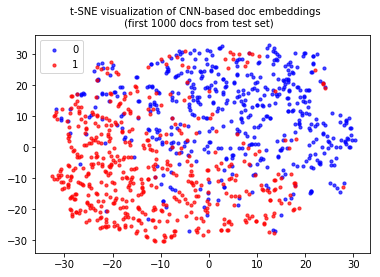

In [26]:
print('plotting embeddings of first',n_plot,'documents')

doc_emb = get_doc_embedding([np.array(x_test[:n_plot]),0])[0]

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=10)
doc_emb_pca = my_pca.fit_transform(doc_emb) 
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca)

fig, ax = plt.subplots()

for label in list(set(labels_plt)):
    idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
    ax.scatter(doc_emb_tsne[idxs,0], 
               doc_emb_tsne[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of CNN-based doc embeddings \n (first 1000 docs from test set)',fontsize=10)
fig.set_size_inches(6,4)
#fig.savefig(path_to_plot + 'doc_embeddings.pdf',bbox_inches='tight')
fig.show()

### Predictive text regions
Here we follow the approach of [Effective Use of Word Order for Text Categorization with Convolutional Neural Networks (Johnson and Zhang, NAACL 2015)](https://arxiv.org/pdf/1412.1058.pdf) (see Tables 5 and 6).

The feature maps that we find at the output of the convolutional layer provide region embeddings (in an `nb_filters`-dimensional space). There are `max_size-filter_size+1` regions of size `filter_size` in an input of size `max_size`. For a given document, we want to identify the `n_show` regions that are associated with the highest weights in the feature map. We can see that the CNN uses regions of the input documents that make sense to us as humans to classify the documents. It picks up the critics and compliments. For the first review, the model was fooled by the presence of ambiguous patterns (e.g., `irrelevant quality`) and predicted the wrong class.

In [29]:
get_region_embedding = K.function([model.layers[0].input,K.learning_phase()],
                                  [model.layers[3].output])

reg_emb = get_region_embedding([np.array(x_test[:100]),0])[0]


get_softmax = K.function([model.layers[0].input,K.learning_phase()],
                         [model.layers[6].output])
predictions = get_softmax([np.array(x_test[:100]),0])[0] # predictions are probabilities of belonging to class 1

# note: you can also use directly: predictions = model.predict(x_test[:100]).tolist()

n_doc_per_label = 2
idx_pos = [idx for idx,elt in enumerate(y_test) if elt==1]
idx_neg = [idx for idx,elt in enumerate(y_test) if elt==0]
my_idxs = idx_pos[:n_doc_per_label] + idx_neg[:n_doc_per_label]

reg_emb_subset = reg_emb[my_idxs,:]
x_test_subset = [elt for idx,elt in enumerate(x_test) if idx in my_idxs]
y_test_subset = [elt for idx,elt in enumerate(y_test) if idx in my_idxs]
predictions_subset = [elt for idx,elt in enumerate(predictions) if idx in my_idxs]

n_show = 3

for idx,doc in enumerate(x_test_subset):
        
    tokens = [index_to_word[elt] for elt in doc if elt!=0] # the 0 index is for padding
    
    # extract regions (sliding window over text)
    regions = []
    regions.append(' '.join(tokens[:filter_size]))
    for i in range(filter_size, len(tokens)):
        regions.append(' '.join(tokens[(i-filter_size+1):(i+1)]))
    
    print('\n *********')
    print('===== text: =====')
    print(' '.join(tokens))
    print('===== label:',y_test_subset[idx],'=====')
    print('===== prediction:',predictions_subset[idx],'=====')
    norms = np.linalg.norm(reg_emb_subset[idx,:,:],axis=1)
    print('===== most predictive regions: =====')
    print([elt for idxx,elt in enumerate(regions) if idxx in np.argsort(norms)[-n_show:]]) # sort by increasing order


 *********
===== text: =====
cat brain series extremely violent sequences together plot feels describing director lucio fulci's most notorious years making could also seen dark comedy sorts effectively various claims violent cinema causes violence real life fulci goes further than casts himself star central figure thus showing audience man behind cinematic gore cat brain presenting clear story following instead fun clich been surrounding horror genre years lucio fulci plays himself horror director struggling keep humanity intact years violent making finally began reach him starts slowly meat general begin disgust him colleagues assure fulci needs rest doesn't help soon grotesque ideas movies begin daily thoughts attempt find cure dangerously mental state lucio starts going local psychiatrist unfortunately does wrong than fulci thrown into even bigger mess psychiatrist turns psychopath murders fulci's films real life retains italian splatter cinema bad here any comments acting technica

### Saliency maps
Here we follow one of the approaches proposed in [Visualizing and Understanding Neural Models in NLP (Li et al. 2015)](https://arxiv.org/abs/1506.01066).

The idea is to rank the elements of the input document based on their influence on the prediction. An approximation can be given by the magnitudes of the first-order partial derivatives of the output of the model with respect to each word in the input document. The interpretation is that we identify which words in the document need to be *changed the least to change the class score the most*. The derivatives can be obtained by performing a single back-propagation pass (note we backpropagate the class score and not the loss like during training).


In [33]:
print(len(x_test_subset))

4


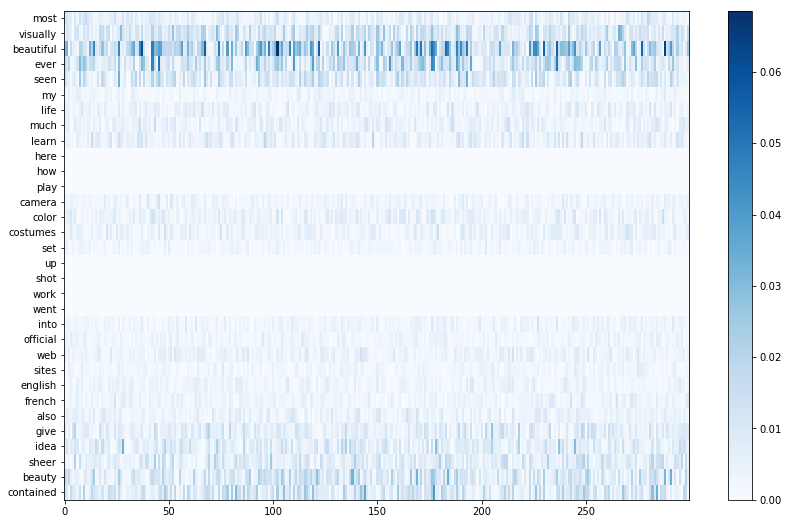

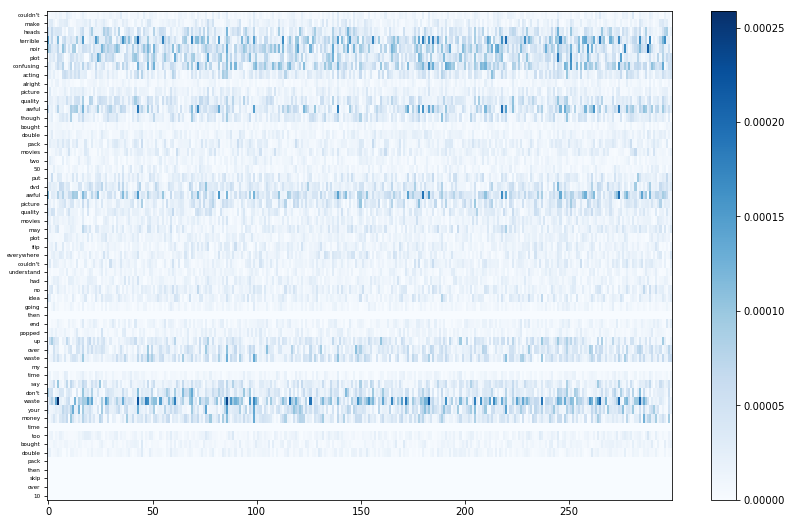

In [39]:
input_tensors = [model.input, K.learning_phase()]
saliency_input = model.layers[3].input # before convolution
saliency_output = model.layers[6].output # class score
gradients = model.optimizer.get_gradients(saliency_output,saliency_input)
compute_gradients = K.function(inputs=input_tensors,outputs=gradients)

for doc in [x_test_subset[1],x_test_subset[3]]:
    matrix = compute_gradients([np.array([doc]),0])[0][0,:,:]
    tokens = [index_to_word[elt] for elt in doc if elt!=0]
    to_plot = np.absolute(matrix[:len(tokens),:])
    fig, ax = plt.subplots()
    heatmap = ax.imshow(to_plot, cmap=plt.cm.Blues, interpolation='nearest',aspect='auto')
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_yticklabels(tokens)
    ax.tick_params(axis='y', which='major', labelsize=32*10/len(tokens))
    fig.colorbar(heatmap)
    fig.set_size_inches(14,9)
    fig.show()